In [52]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from confusion_matrix_pretty_print import plot_confusion_matrix_from_data as plot_matrix

df = pd.read_csv("./creditcard.csv")

In [53]:
#Gathering Data Insight
print("Data =>\nrows:",df.shape[0],"\ncolumns:", df.shape[1])
print("No. of Normal Cases: ",df['Class'].value_counts()[0])
print("Fraud Cases: ",df['Class'].value_counts()[1])

Data =>
rows: 284807 
columns: 31
No. of Normal Cases:  284315
Fraud Cases:  492


In [54]:
#Data Verification
df.isnull().any().any()

False

In [55]:
#Normalizing the Amount Column
from sklearn.preprocessing import StandardScaler

df['Amount_Normalized'] = StandardScaler().fit_transform(df['Amount'].values.reshape(-1, 1))
df_Norm = df.drop(['Time','Amount'],axis=1)
df_Norm.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Class,Amount_Normalized
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,0.244964
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.342475
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,1.160686
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,0.140534
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,-0.073403


In [56]:
y = df_Norm['Class']
X = df_Norm.drop('Class', axis=1)

In [101]:
# Number of data points in the minority class
number_records_fraud = len(df_Norm[df_Norm.Class == 1])
fraud_indices = np.array(df_Norm[df_Norm.Class == 1].index)

# Picking the indices of the normal classes
normal_indices = df_Norm[df_Norm.Class == 0].index

# Out of the indices we picked, randomly select "x" number (number_records_fraud)
random_normal_indices = np.random.choice(normal_indices, number_records_fraud, replace = False)
random_normal_indices = np.array(random_normal_indices)

# Appending the 2 indices
under_sample_indices = np.concatenate([fraud_indices,random_normal_indices])

# Under sample dataset
under_sample_data = df_Norm.iloc[under_sample_indices,:]

X_undersample = under_sample_data.iloc[:, under_sample_data.columns != 'Class']
y_undersample = under_sample_data.iloc[:, under_sample_data.columns == 'Class']

# Showing ratio
print("Percentage of normal transactions: ", len(under_sample_data[under_sample_data.Class == 0])/len(under_sample_data))
print("Percentage of fraud transactions: ", len(under_sample_data[under_sample_data.Class == 1])/len(under_sample_data))
print("Total number of transactions in resampled data: ", len(under_sample_data))

Percentage of normal transactions:  0.5
Percentage of fraud transactions:  0.5
Total number of transactions in resampled data:  984


In [121]:
from sklearn.cross_validation import train_test_split

# Whole dataset
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3, random_state = 0)

print("Rows in training dataset: ", len(X_train))
print("Rows in test dataset: ", len(X_test))

# Undersampled dataset
X_train_undersample, X_test_undersample, y_train_undersample, y_test_undersample = train_test_split(X_undersample
                                                                                                   ,y_undersample
                                                                                                   ,test_size = 0.3
                                                                                                   ,random_state = 0)
print("")
print("Rows in training undersample dataset: ", len(X_train_undersample))
print("Rows in test undersample dataset: ", len(X_test_undersample))
print("Total number: ", len(X_train_undersample)+len(X_test_undersample))

Rows in training dataset:  199364
Rows in test dataset:  85443

Rows in training undersample dataset:  688
Rows in test undersample dataset:  296
Total number:  984


In [122]:
#PARAMETER Tuning for Undersampled data
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
grid={"C":np.logspace(-1,2,1), "penalty":["l1","l2"]}# l1 lasso l2 ridge
LR=LogisticRegression()
LR_C=GridSearchCV(LR,grid,cv=2)
LR_C.fit(X_train_undersample,y_train_undersample.values.ravel())
c_value = LR_C.best_params_['C']
penalty_value = LR_C.best_params_['penalty']

print ("tuned hpyerparameters :(best parameters) ",LR_C.best_params_)
print ("accuracy :",LR_C.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 0.1, 'penalty': 'l2'}
accuracy : 0.9302325581395349


In [123]:
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import KFold, cross_val_score
from sklearn.metrics import confusion_matrix,precision_recall_curve,auc,roc_auc_score,roc_curve,recall_score,classification_report,accuracy_score 
lr = LogisticRegression(C = c_value, penalty = penalty_value)
lr.fit(X_train_undersample,y_train_undersample.values.ravel())
y_pred_undersample = lr.predict(X_test_undersample.values)

cnf_matrix = confusion_matrix(y_test_undersample,y_pred_undersample)

print("Recall: ", cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))
print("Accuracy" ,accuracy_score(y_test_undersample,y_pred_undersample))



Recall:  0.9183673469387755
Accuracy 0.9425675675675675


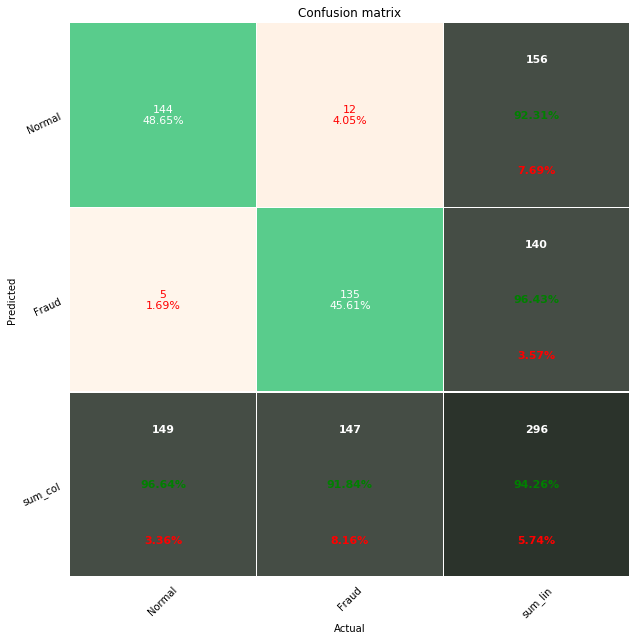

In [124]:
plot_matrix(y_test_undersample,y_pred_undersample, ['Normal', 'Fraud'])

In [125]:
#PARAMETER Tuning for Undersampled data
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
grid={"C":np.logspace(-1,2,1), "penalty":["l1","l2"]}# l1 lasso l2 ridge
LR=LogisticRegression()
LR_C=GridSearchCV(LR,grid,cv=2)
LR_C.fit(X_train,y_train.values.ravel())
c_value = LR_C.best_params_['C']
penalty_value = LR_C.best_params_['penalty']

print ("tuned hpyerparameters :(best parameters) ",LR_C.best_params_)
print ("accuracy :",LR_C.best_score_)



tuned hpyerparameters :(best parameters)  {'C': 0.1, 'penalty': 'l2'}
accuracy : 0.9991623362292089


In [126]:

from sklearn.metrics import confusion_matrix,precision_recall_curve,auc,roc_auc_score,roc_curve,recall_score,classification_report,accuracy_score 
lr = LogisticRegression(C = c_value, penalty = penalty_value)
lr.fit(X_train,y_train.values.ravel())
y_pred = lr.predict(X_test.values)

cnf_matrix = confusion_matrix(y_test,y_pred)
np.set_printoptions(precision=2)

print("Recall: ", cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))
print("Accuracy: ", accuracy_score(y_test,y_pred))




Recall:  0.5986394557823129
Accuracy:  0.99916903666772


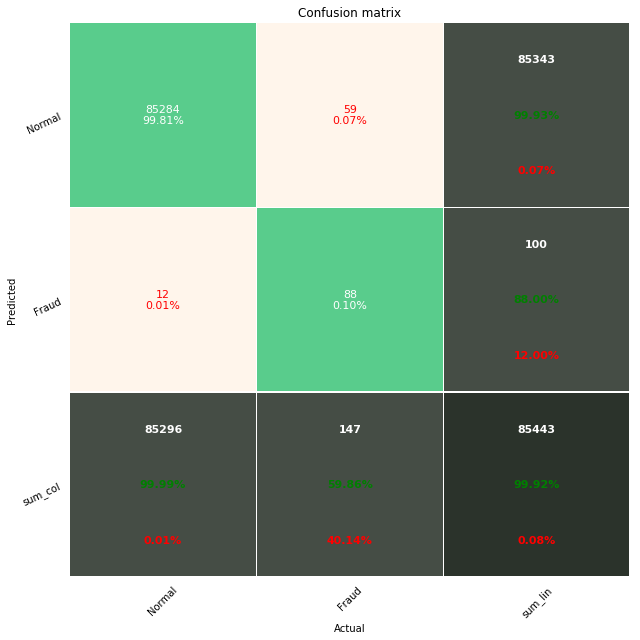

In [127]:
plot_matrix(y_test,y_pred,['Normal', 'Fraud'])